# Gene set enrichment analysis of rho scores
- tool: blitzgsea, https://github.com/MaayanLab/blitzgsea

In [1]:
import numpy as np 
import pandas as pd
import anndata as ad
import scanpy as sc
import blitzgsea as blitz

import screenpro

from matplotlib import font_manager as fm

from matplotlib import rcParams

font_files = fm.findSystemFonts(fontpaths=None, fontext='ttf')

for font_file in font_files:
    fm.fontManager.addfont(font_file)

# {f.name for f in matplotlib.font_manager.fontManager.ttflist}

rcParams['font.family'] = ['Arial']

from screenpro.load import loadScreenProcessingData, read_adata_pkl

In [2]:
pager_dir = "/data_gilbert/home/aarab/tools/pager/"
pager_annotation_path = '/data_gilbert/home/aarab/tools/pager/annotations/human'

c5_gobp_gmt = blitz.enrichr.read_gmt(
    f'{pager_annotation_path}/msigdb_v7.4_c5.go.bp/c5.go.bp.v7.4.symbols.gmt'
)

In [3]:
def get_sig_gsea_results(result,variable,threshold):
    return result[result[variable] < threshold]

def get_rho_for_gsea(rho,ctrl_label='pseudo'):
    
    rho = rho.loc[~rho.label.eq(ctrl_label),:]

    rho_score = rho.score.reset_index()
    rho_score = rho_score.dropna()
    
    rho_stat =  1 - rho.pvalue # regardless of direction
    rho_stat = rho_stat.reset_index()
    rho_stat = rho_stat.dropna()
    
    return rho_score, rho_stat

# def run_rho_gsea(rho,gmt,min_size=200):
#     signature = rho.copy()

#     result = blitz.gsea(
#         signature=signature,
#         library=gmt,
#         min_size=min_size,
#         # max_size=250,
#         verbose=True
#     )
    
#     return signature, result

def run_rho_gsea_directional(rho,gmt,min_size=15,max_size=150):
    signature = rho.copy()

    result = blitz.gsea(
        signature=signature,
        library=gmt,
        min_size=min_size,
        max_size=max_size,
        verbose=True
    )
    
    return signature, result

In [4]:
# import sys
# import pandas as pd
# from itertools import chain, product

# sys.path.append("../../")

# from scripts.util import *
# from matplotlib_venn import venn2
# from IPython.display import IFrame

In [5]:
# import gseapy

### Get phenotype scores

In [6]:
threshold = 10

In [7]:
Ci_prdx1kd_adata = read_adata_pkl('datasets/CRISPRi_PRDX1-KD')

In [8]:
Ci_adata = read_adata_pkl('datasets/CRISPRi')
Ca_A549_adata = read_adata_pkl('datasets/CRISPRa_A549')
Ca_k562_adata = read_adata_pkl('datasets/CRISPRa_k562')

In [9]:
def get_annotated_score_df(adata,score,level,threshold,ctrl_label='pseudo',rep_label='ave_rep1_rep2'):
    if level == 'transcript':
        df = adata.transcript_scores[score][rep_label][[
            'average phenotype of strongest 3',
            'Mann-Whitney p-value',
        ]].reset_index('gene').reset_index(drop=True).copy()
    
    elif level == 'gene':
        df = adata.gene_scores[score][rep_label][[
            'average phenotype of strongest 3',
            'Mann-Whitney p-value',
        ]].reset_index('gene').copy()
        
    df = screenpro.phenoScore.ann_score_df(df, ctrl_label=ctrl_label,threshold=threshold)
    
    return df

In [10]:
def add_rho_dict(adata,threshold = threshold,rep_label = 'ave_rep1_rep2'):
    adata.rho_dict = dict([
        (treat,get_annotated_score_df(adata,score,'gene',threshold = threshold, rep_label = rep_label).set_index('target')) 
        for treat, score in adata.comparisons.items()
    ])

___

In [11]:
add_rho_dict(Ci_adata)

In [12]:
add_rho_dict(Ca_A549_adata,rep_label='Rep1') # there are only one replicates per condition

In [13]:
add_rho_dict(Ca_k562_adata)

## Run GSEA

In [36]:
def run_gesa_loop(rho_dict,ctrl_label='pseudo', gmt = c5_gobp_gmt):
    results = {}
    for treat, rho in rho_dict.items():
        print(treat)
        rho_score, _ = get_rho_for_gsea(rho,ctrl_label=ctrl_label)

        signature, result = run_rho_gsea_directional(rho_score,c5_gobp_gmt)

        result_top = get_sig_gsea_results(result,'fdr',0.2)

        results[treat] = {'signature':signature,'full':result,'top':result_top} #,'gmt':gmt

        del signature,result,result_top,rho_score
    return results


def save_gesa_results(results,results_dir,exp_name):
    writer = pd.ExcelWriter(f'{results_dir}/{exp_name}_go_gsea.xlsx', engine='openpyxl')

    for name,res in results.items():
        res['top'].to_excel(writer, sheet_name=f'{exp_name} {name}')

    # writer.save()
    writer.close()

    all_terms = [res['full'].index.to_list() for name,res in results.items()]
    ol_terms  = list(set(all_terms[0]).intersection(*all_terms[1:]))
    
    pd.concat(
        dict([(name,res['full'].loc[ol_terms,:]) for name,res in results.items()]),axis=1
    ).to_excel(f'{results_dir}/{exp_name}_go_gsea_merged.xlsx')

___

In [37]:
# run_gesa_loop

#### CRISPRi PRDX1-KD datasets

This is a different analysis so the threshold, etc. might be different from the V2 datasets.

In [32]:
Ci_prdx1kd_adata.rho_dict = dict([
    (score, Ci_prdx1kd_adata.gene_scores[score])
    for score in Ci_prdx1kd_adata.gene_scores.columns.get_level_values(0).unique()
])

In [38]:
# run_gesa_loop

In [39]:
Ci_prdx1kd_adata.gsea_results = run_gesa_loop(Ci_prdx1kd_adata.rho_dict,ctrl_label='non-targeting')

PRDX1_parent gamma vehicle_vs_T0


Enrichment : 100%|██████████| 7481/7481 [00:03<00:00, 2018.82it/s]
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


Kolmogorov-Smirnov test failed. Gamma approximation deviates from permutation samples.
KS p-value (pos): 0.027268607720722794
KS p-value (neg): 0.027268607720722794
PRDX1_parent tau DNAPKi_vs_T0


Enrichment : 100%|██████████| 7481/7481 [00:03<00:00, 2026.73it/s]
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


Kolmogorov-Smirnov test failed. Gamma approximation deviates from permutation samples.
KS p-value (pos): 0.021039625372262147
KS p-value (neg): 0.021039625372262147
PRDX1_parent rho DNAPKi_vs_vehicle


Enrichment : 100%|██████████| 7481/7481 [00:03<00:00, 1975.55it/s]
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


PRDX1_KO gamma vehicle_vs_T0


Enrichment : 100%|██████████| 7481/7481 [00:03<00:00, 2043.94it/s]
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


Kolmogorov-Smirnov test failed. Gamma approximation deviates from permutation samples.
KS p-value (pos): 0.02950274101154328
KS p-value (neg): 0.02950274101154328
PRDX1_KO tau DNAPKi_vs_T0


Enrichment : 100%|██████████| 7481/7481 [00:03<00:00, 2141.86it/s]
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


PRDX1_KO rho DNAPKi_vs_vehicle


Enrichment : 100%|██████████| 7481/7481 [00:03<00:00, 1894.92it/s]
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


Kolmogorov-Smirnov test failed. Gamma approximation deviates from permutation samples.
KS p-value (pos): 0.014055002002954446
KS p-value (neg): 0.014055002002954446
vehicle rho PRDX1KO_vs_parent


Enrichment : 100%|██████████| 7481/7481 [00:03<00:00, 2074.29it/s]
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


Kolmogorov-Smirnov test failed. Gamma approximation deviates from permutation samples.
KS p-value (pos): 0.048906725646048324
KS p-value (neg): 0.048906725646048324


#### CRISPRi

In [15]:
Ci_adata.gsea_results = run_gesa_loop(Ci_adata.rho_dict)

gamma


Enrichment : 100%|██████████| 7481/7481 [00:04<00:00, 1551.16it/s]
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


Kolmogorov-Smirnov test failed. Gamma approximation deviates from permutation samples.
KS p-value (pos): 0.03235275063257275
KS p-value (neg): 0.03235275063257275
PARPi


Enrichment : 100%|██████████| 7481/7481 [00:04<00:00, 1625.16it/s]
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


DNAPKi


Enrichment : 100%|██████████| 7481/7481 [00:04<00:00, 1632.29it/s]
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


ATMi


Enrichment : 100%|██████████| 7481/7481 [00:04<00:00, 1609.44it/s]
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


ATRi


Enrichment : 100%|██████████| 7481/7481 [00:04<00:00, 1700.43it/s]
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


WEE1i


Enrichment : 100%|██████████| 7481/7481 [00:04<00:00, 1718.79it/s]
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


PARPi+DNAPKi


Enrichment : 100%|██████████| 7481/7481 [00:04<00:00, 1647.62it/s]
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


PARPi+ATMi


Enrichment : 100%|██████████| 7481/7481 [00:04<00:00, 1798.64it/s]
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


PARPi+ATRi


Enrichment : 100%|██████████| 7481/7481 [00:04<00:00, 1584.19it/s]
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


PARPi+WEE1i


Enrichment : 100%|██████████| 7481/7481 [00:04<00:00, 1759.71it/s]
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


#### CRISPRa

In [16]:
Ca_k562_adata.gsea_results = run_gesa_loop(Ca_k562_adata.rho_dict)

gamma


Enrichment : 100%|██████████| 7481/7481 [00:04<00:00, 1720.11it/s]
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


rho1


Enrichment : 100%|██████████| 7481/7481 [00:04<00:00, 1667.68it/s]
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


rho2


Enrichment : 100%|██████████| 7481/7481 [00:04<00:00, 1668.00it/s]
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


In [17]:
Ca_A549_adata.gsea_results = run_gesa_loop(Ca_A549_adata.rho_dict)

gamma


Enrichment : 100%|██████████| 7481/7481 [00:04<00:00, 1579.69it/s]
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


PARPi


Enrichment : 100%|██████████| 7481/7481 [00:04<00:00, 1619.63it/s]
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


ATRi


Enrichment : 100%|██████████| 7481/7481 [00:04<00:00, 1631.03it/s]
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


WEE1i


Enrichment : 100%|██████████| 7481/7481 [00:04<00:00, 1756.76it/s]
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


PARPi+ATRi


Enrichment : 100%|██████████| 7481/7481 [00:04<00:00, 1605.70it/s]
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


PARPi+WEE1i


Enrichment : 100%|██████████| 7481/7481 [00:04<00:00, 1831.25it/s]
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


### save as excel files

In [18]:
mkdir -p results/gsea/

In [40]:
save_gesa_results(Ci_prdx1kd_adata.gsea_results,'results/gsea/','CRISPRi_PRDX1-KD')

/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


In [19]:
save_gesa_results(Ci_adata.gsea_results,'results/gsea/','CRISPRi')

In [20]:
save_gesa_results(Ca_A549_adata.gsea_results,'results/gsea/','CRISPRa_A549')

In [21]:
save_gesa_results(Ca_k562_adata.gsea_results,'results/gsea/','CRISPRa_K562')

___

In [22]:
# pd.concat(dict([
#     (k, results[k]['top'][results[k]['top'].leading_edge.str.contains('PRDX1')])
#     for k in results.keys()
# ])).to_excel('results/go_with_prdx1.xlsx')

### GSEA plots

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
from matplotlib.backends.backend_pdf import PdfPages

def save_image(figs,filename):
    
    # PdfPages is a wrapper around pdf 
    # file so there is no clash and create
    # files with no error.
    p = PdfPages(filename)
      
    # iterating over the numbers in list
    for fig in figs: 
        
        # and saving the files
        fig.savefig(p, format='pdf',bbox_inches='tight') 
      
    # close the object
    p.close()  

#### sensitivity_genesets

In [25]:
# fig_list = []

# for treat in results.keys():
#     fig = blitz.plot.top_table(
#         results[treat]['signature'],
#         results[treat]['gmt'],
#         results[treat]['top'].query('nes < -2')
#     )

#     fig.suptitle(treat,fontsize=20)
    
#     fig_list.append(fig)

# save_image(fig_list,'go_gsea_top_sensitivity_genesets.pdf')

#### resistance_genesets

In [26]:
# fig_list = []

# for treat in results.keys():
#     fig = blitz.plot.top_table(
#         results[treat]['signature'],
#         results[treat]['gmt'],
#         results[treat]['top'].query('nes > 2')
#     )

#     fig.suptitle(treat,fontsize=20)
    
#     fig_list.append(fig)

# save_image(fig_list,'go_gsea_top_resistance_genesets.pdf')

# 

___

In [27]:
def get_rho_bin(rho_dict):
    rho_df = pd.concat(dict([(treat,rho.score) for treat, rho in rho_dict.items() if treat != 'gamma']),axis=1)

    rho_label = pd.concat(dict([(treat,rho.label) for treat, rho in rho_dict.items() if treat != 'gamma']),axis=1)

    rho_bin = pd.DataFrame(0,index=rho_label.index,columns=rho_label.columns)

    rho_bin = (rho_label.isin(['sensitivity_hit']) * -1) + (rho_label.isin(['resistance_hit']) * 1)
    # rho_bin = rho_bin[~rho_bin.eq(0).sum(axis=1).eq(rho_bin.shape[1])]

    return rho_bin #rho_label, 

In [28]:
rho_bin = get_rho_bin(Ci_adata.rho_dict)

/tmp/ipykernel_298669/1739242122.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


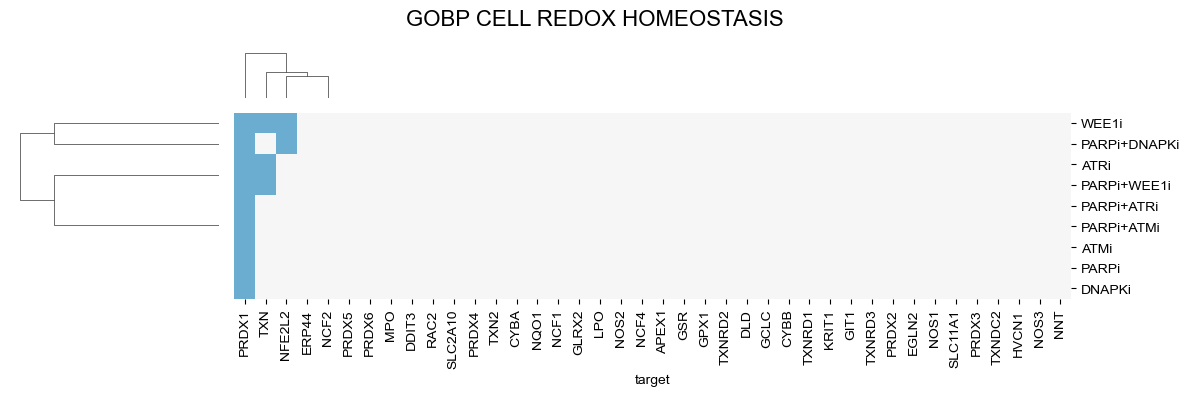

In [29]:
g = sns.clustermap(
    rho_bin.loc[list(set(c5_gobp_gmt['GOBP_CELL_REDOX_HOMEOSTASIS']) & set(rho_bin.index)),:].T,
    cmap='RdBu_r',
    vmin=-2,
    vmax=2,
    figsize=(12,4),
)

g.fig.suptitle('GOBP CELL REDOX HOMEOSTASIS',size=16) 
g.cax.set_visible(False)

plt.tight_layout()
g.savefig('GOBP_CELL_REDOX_HOMEOSTASIS.pdf')
plt.show()

# 

In [30]:
from watermark import watermark
print(
    watermark()
)
print('_'*80)
print(
    watermark(iversions=True, globals_=globals())
)

Last updated: 2023-08-15T12:14:38.292502-07:00

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.14.0

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 3.10.0-957.27.2.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit

________________________________________________________________________________
numpy     : 1.24.4
screenpro : 0.2.1
seaborn   : 0.12.2
anndata   : 0.9.1
pandas    : 2.0.3
scanpy    : 1.9.3
matplotlib: 3.7.2
blitzgsea : 1.3.34

